<a href="https://colab.research.google.com/github/lauren-safwat/Head-Pose-Estimation/blob/main/Head_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installing MediaPipe

In [1]:
%%capture
!pip install mediapipe

### Imports

In [2]:
import numpy as np
import pandas as pd
import mediapipe as mp
import scipy.io as sio
import cv2
import os
import glob
import random
from pathlib import Path
from math import sin, cos
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score,f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### Downloading Data

In [3]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

# **Data Preparation and Preprocessing**

In [4]:
mp_faceModule = mp.solutions.face_mesh
face_mesh = mp_faceModule.FaceMesh(static_image_mode=True)

# Load drawing_utils and drawing_styles
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

In [8]:
def createRecord(image, mat_file=None):
    # Convert the BGR image to RGB before processing.
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    records = []
    if results.multi_face_landmarks != None: 
        # Looping over the faces in the image
        for face in results.multi_face_landmarks:
            record = {}

            # Nose landmarks to center all the points around it
            center_x = face.landmark[4].x * image.shape[1]
            center_y = face.landmark[4].y * image.shape[0]

            # Forehead midpoint landmarks
            x_10 = face.landmark[10].x * image.shape[1]
            y_10 = face.landmark[10].y * image.shape[0]

            # The distance between the points to be used to normalize the data
            distance = np.linalg.norm(np.array((x_10, y_10)) - np.array((center_x, center_y)))

            # Extracting the landmark points (468 points)
            for i, landmark in enumerate(face.landmark):
                record['x_' + str(i+1)] = (landmark.x * image.shape[1] - center_x) / distance
                record['y_' + str(i+1)] = (landmark.y * image.shape[0] - center_y) / distance

            # Extracting the 3 angels of the face (pitch, yaw, roll)
            if mat_file:
                pose_para = mat_file["Pose_Para"][0][:3]
                record['pitch'] = pose_para[0]
                record['yaw'] = pose_para[1]
                record['roll'] = pose_para[2]

            records.append(record)
    
    return records
            

In [9]:
def prepareTrainData(path):
    data = []
    for filename in glob.glob(path + '/*.jpg'):
        # Loading the image and its corresponding mat file
        image = cv2.imread(filename)
        mat_file = sio.loadmat(filename.replace('.jpg', '.mat'))
        data.extend(createRecord(image, mat_file))

    return pd.DataFrame(data)                

In [10]:
path = '/content/AFLW2000'
train_data = prepareTrainData(path)

In [11]:
X = train_data.iloc[:, :-3]
y = train_data.iloc[:, -3:]

In [12]:
X.head()

,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,x_5,y_5,...,x_464,y_464,x_465,y_465,x_466,y_466,x_467,y_467,x_468,y_468
0,0.026106,0.340115,0.004771,0.080636,0.019087,0.167931,-0.058947,-0.162972,0.0,0.0,...,0.217605,-0.349673,0.171794,-0.332027,0.144046,-0.321676,0.581731,-0.420341,0.619606,-0.446135
1,0.158939,0.229277,0.022531,0.056590,0.149547,0.092527,0.032839,-0.164030,0.0,0.0,...,0.365326,-0.438807,0.322625,-0.407381,0.282324,-0.378018,0.665627,-0.490685,0.707372,-0.551364
2,0.021175,0.210326,0.005352,0.059136,0.008260,0.088879,-0.065815,-0.166927,0.0,0.0,...,0.123535,-0.424321,0.091557,-0.399491,0.075360,-0.376896,0.421580,-0.525411,0.446950,-0.545525
3,0.043380,0.304823,-0.002919,0.068195,0.085035,0.149328,0.063104,-0.170670,0.0,0.0,...,0.473607,-0.294826,0.422793,-0.284252,0.379440,-0.274105,0.839405,-0.220582,0.889625,-0.236704
4,-0.195762,0.333656,-0.051228,0.065956,-0.064709,0.203531,0.107291,-0.108699,0.0,0.0,...,0.528000,0.050261,0.471967,0.023811,0.431023,-0.000591,0.852858,0.293932,0.922099,0.300239


In [13]:
y.head()

,pitch,yaw,roll
0,0.075391,0.066288,-0.076080
1,-0.514121,0.752342,-0.341487
2,-0.347319,-0.027759,-0.091287
3,-0.029032,0.567679,0.240908
4,0.442086,0.223025,0.786156


# **Data Visualization**

In [14]:
def draw_axis(img, pitch, yaw, roll, size = 100):

    yaw = -yaw

    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    tdx = int(results.multi_face_landmarks[0].landmark[4].x * img.shape[1])
    tdy = int(results.multi_face_landmarks[0].landmark[4].y * img.shape[0])

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

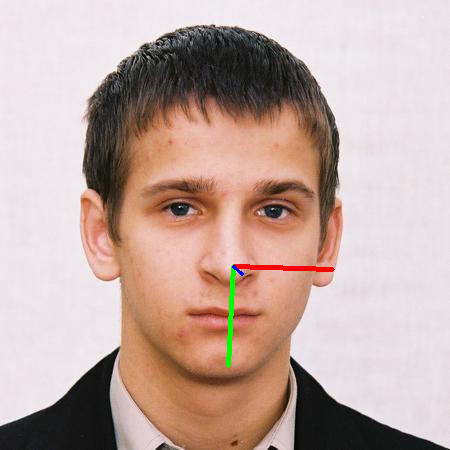

In [15]:
random_file = 'image00053'
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')

# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image, pitch, yaw, roll))

# **Model Training**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=256)

## Multi-Output Regressor with SVR

In [17]:
svr_model = MultiOutputRegressor(SVR(kernel='rbf'))
svr_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=SVR())

In [18]:
preds = svr_model.predict(X_test)
r2_score(y_test, preds)

0.8871874498929261

## Multi-Output Regressor with Random Forest Regressor

In [19]:
rf_model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100))
rf_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [20]:
preds = rf_model.predict(X_test)
r2_score(y_test, preds)

0.6606201832021026

## Multi-Output Regressor with XGBoost

In [21]:
xgb_model = MultiOutputRegressor(XGBRegressor(objective = 'reg:squarederror'))
xgb_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(objective='reg:squarederror'))

In [22]:
preds = xgb_model.predict(X_test)
r2_score(y_test, preds)

0.5586825488005401

## Random Forest Regression Model for each label

In [23]:
pitch_model = RandomForestRegressor(n_estimators=100, max_depth=128, random_state=0).fit(X_train, y_train['pitch'])
yaw_model   = RandomForestRegressor(n_estimators=100, max_depth=128, random_state=0).fit(X_train, y_train['yaw'])
roll_model  = RandomForestRegressor(n_estimators=100, max_depth=128, random_state=0).fit(X_train, y_train['roll'])

In [24]:
print(pitch_model.score(X_train, y_train['pitch']))
print(yaw_model.score(X_train, y_train['yaw']))
print(roll_model.score(X_train, y_train['roll']))
print()
print(pitch_model.score(X_test, y_test['pitch']))
print(yaw_model.score(X_test, y_test['yaw']))
print(roll_model.score(X_test, y_test['roll']))

0.8525013495931354
0.9735812769443611
0.8446418952184589

0.6399458844500265
0.9550247944187944
0.29067919538004994


# **Testing on video**

In [ ]:
from google.colab import files
uploaded = files.upload()

In [25]:
cap = cv2.VideoCapture('Mohand.mp4')
frames = []

while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break
    height, width, layers = frame.shape
    size = (width, height)
    features = pd.DataFrame(createRecord(frame))

    if features.empty:
        continue

    labels = svr_model.predict(features)

    out_frame = draw_axis(frame, labels[0][0], labels[0][1], labels[0][2])

    frames.append(out_frame)

In [26]:
video_name = 'Head_Pose_Estimation.mp4'
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for frame in frames:
    video.write(frame)

video.release()
cap.release()
cv2.destroyAllWindows()